# Comparison of Model Outputs

In [1]:
import test_data_preparation
import matplotlib.pyplot as plt
import tensorflow as tf
import models
import numpy as np

2023-01-05 17:59:52.522969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
test_ds = test_data_preparation.get_test_dataset("div2k", batch_size=1)
test_ds = iter(test_ds)

In [49]:
test_im_rgb = next(test_ds)

(0.0, 1.0, 0.0, 1.0)

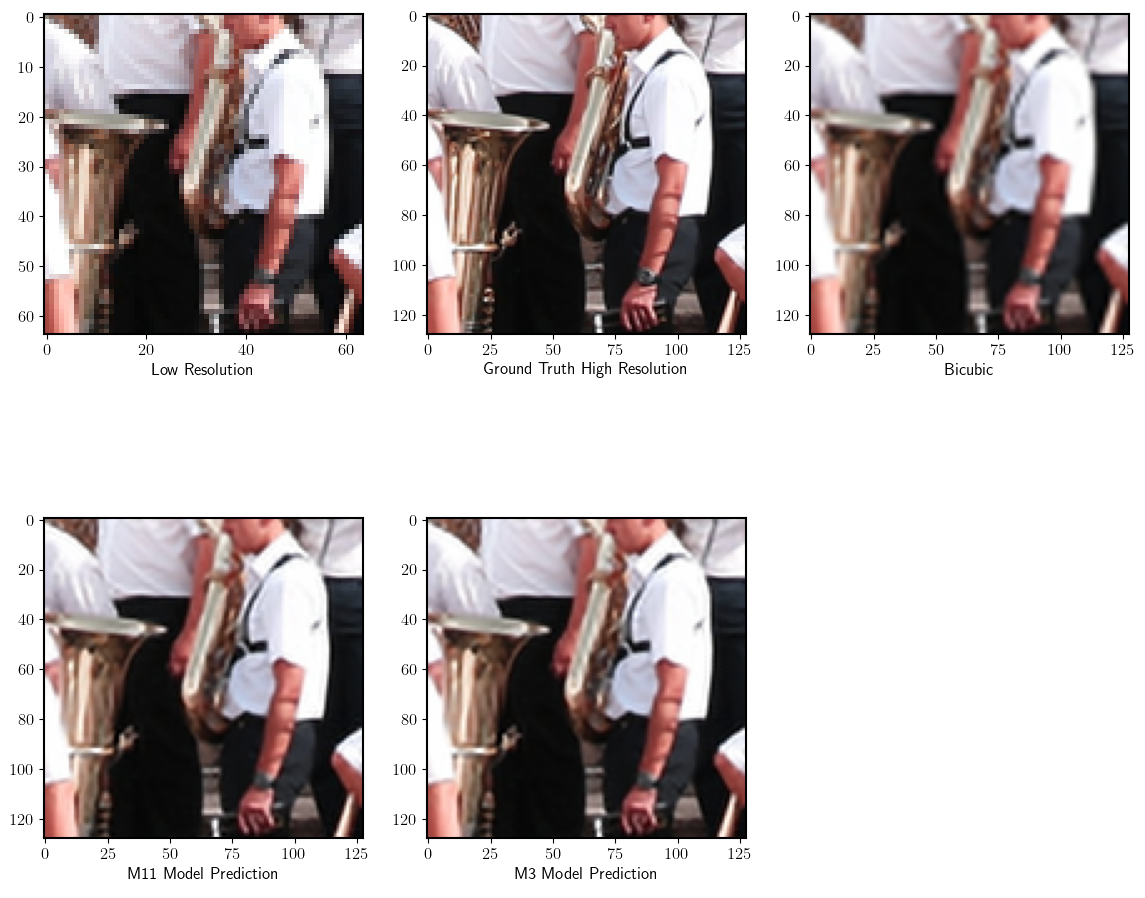

In [50]:
m11_network = models.model.Model(network="M11")
m11_params = np.load("params_M11_300.npz", allow_pickle=True)
m11_params = m11_params['arr_0'].item(0)
m11_model_upscaled_image = test_data_preparation.upscale_image_with_model(test_im_rgb.lr, m11_network, m11_params)[0]/255
m3_network = models.model.Model(network="M3")
m3_params = np.load("params_M3_300.npz", allow_pickle=True)
m3_params = m3_params['arr_0'].item(0)
m3_model_upscaled_image = test_data_preparation.upscale_image_with_model(test_im_rgb.lr, m3_network, m3_params)[0]/255

low_res = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(test_im_rgb.lr[0]))/255
high_res = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(test_im_rgb.hr[0]))/255
bicubic = tf.image.resize(low_res, (128, 128), method="bicubic")

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
fig, (row1, row2) = plt.subplots(2, 3, figsize=(14, 12))
row1[0].imshow(low_res)
row1[0].set_xlabel("Low Resolution")
row1[1].imshow(high_res)
row1[1].set_xlabel("Ground Truth High Resolution")
row1[2].imshow(bicubic)
row1[2].set_xlabel("Bicubic")
row2[0].imshow(m11_model_upscaled_image)
row2[0].set_xlabel("M11 Model Prediction")
row2[1].imshow(m3_model_upscaled_image)
row2[1].set_xlabel("M3 Model Prediction")
row2[2].axis("off")

### RGB -> YCbCr -> RGB does cause minor changes in colour, I believe due to numerical inprecision

Text(0.5, 0, 'Image transformed to YCbCr and back to RGB')

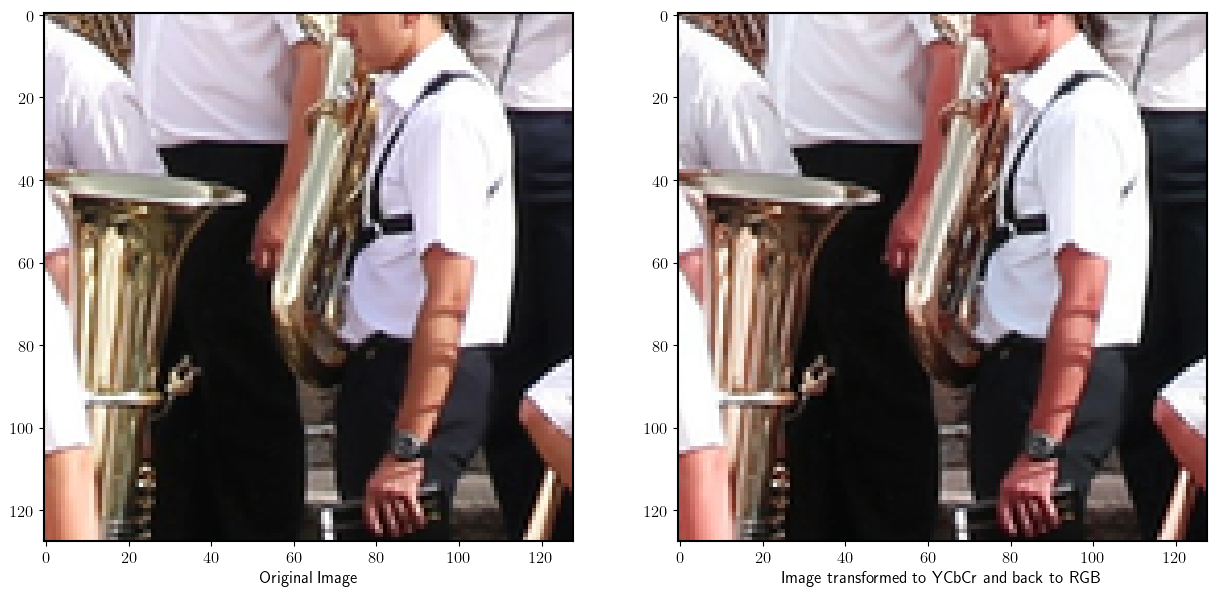

In [52]:
original_high_res = test_im_rgb.hr[0]
transformed_high_res = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(test_im_rgb.hr[0]))/255
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(original_high_res)
ax1.set_xlabel("Original Image")
ax2.imshow(transformed_high_res)
ax2.set_xlabel("Image transformed to YCbCr and back to RGB")

### Random Workings

(1, 64, 64, 3)
(64, 64)


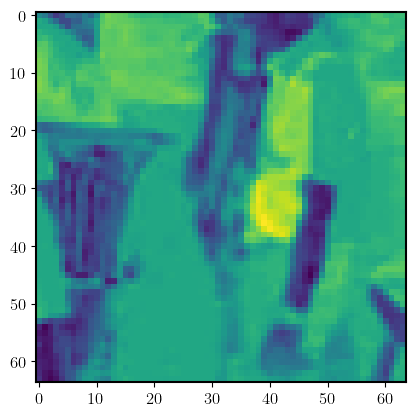

In [53]:
low_res_rgb = test_im_rgb.lr
print(low_res_rgb.shape)
low_res_ycbcr = test_data_preparation.rgb_to_ycbcr(low_res_rgb)
y = low_res_ycbcr[0][..., 0]
cb = low_res_ycbcr[0][..., 1]
cr = low_res_ycbcr[0][..., 2]
print(cb.shape)
plt.imshow(cb/255)

In [13]:
import tensorflow as tf
import jax.numpy as jnp
import models.model

In [15]:
cb_upsampled = tf.image.resize(cb[..., jnp.newaxis], (128, 128))[jnp.newaxis, ...]
cr_upsampled = tf.image.resize(cr[..., jnp.newaxis], (128, 128))[jnp.newaxis, ...]

In [17]:
net_input = y.numpy()[jnp.newaxis, ...][..., jnp.newaxis]/255

In [18]:
network = models.model.Model(network="M11")
best = jnp.load("params_M11_300.npz", allow_pickle=True)
print(type(best['arr_0'].item(0)))
y_upsampled = network.forward(best['arr_0'].item(0), net_input)

<class 'dict'>


In [22]:
full_upsampled_ycbcr = np.concatenate((y_upsampled*255, cb_upsampled), axis=3)
full_upsampled_ycbcr = np.concatenate((full_upsampled_ycbcr, cr_upsampled), axis=3)

In [24]:
rgb_network_upsampled = test_data_preparation.ycbcr_to_rgb(tf.convert_to_tensor(full_upsampled_ycbcr))

In [25]:
rgb_network_upsampled = test_data_preparation.ycbcr_to_rgb(full_upsampled_ycbcr)

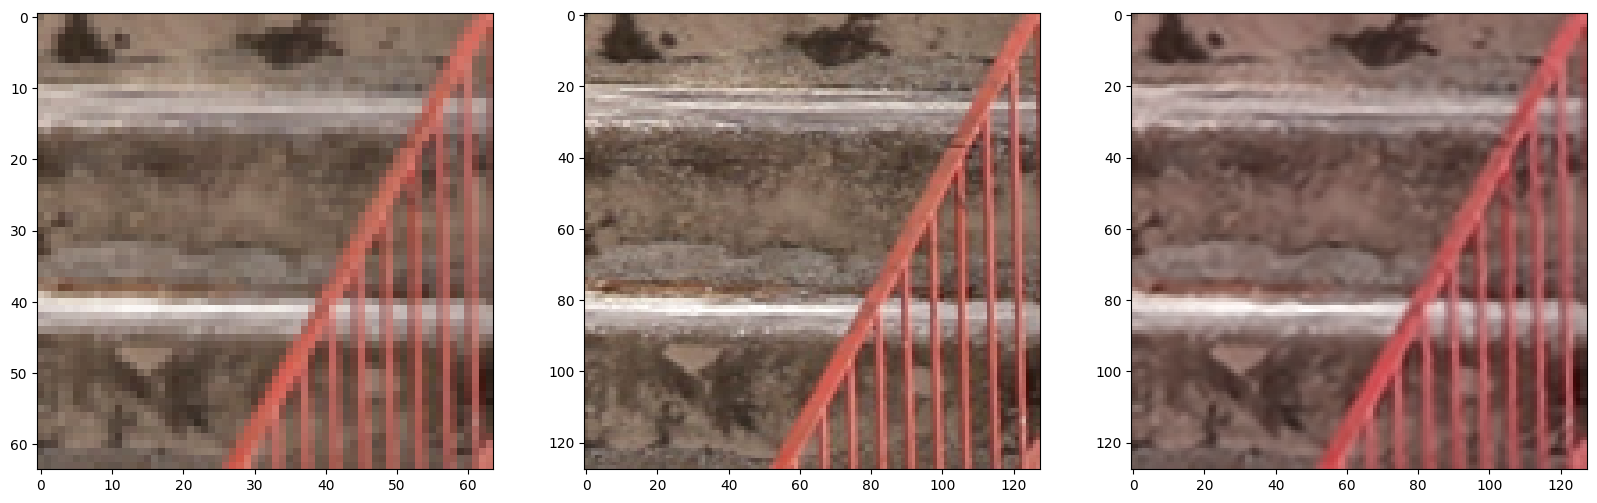

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 12))
ax1.imshow(low_res_rgb[0])
ax2.imshow(high_res_rgb[0])
ax3.imshow(rgb_network_upsampled[0]/255)